In [1]:
import os
import random
from tqdm import tqdm
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import (random_split, DataLoader, TensorDataset, ConcatDataset)
from torch.distributions.categorical import Categorical
import matplotlib.pyplot as plt
from torchsummary import summary
from functools import partial
import pytorch_lightning as pl
from pytorch_lightning.metrics import functional
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import time
import scipy.stats as stats
import seaborn as sns
#import arviz as az

# import sys
# sys.path.append('/content/drive/MyDrive/Python scripts')
# import constants

if torch.cuda.is_available():
    use_cuda = True
    torch.backends.cudnn.benchmark = True
#     dflt_device = torch.device('cuda')
    print(f'GPU available: {torch.cuda.get_device_name(0)} ({torch.cuda.device_count()} count)')
else:
#     dflt_device = torch.device('cpu')
    print('No GPU available')
# print(f'Default device: {dflt_device}')

GPU available: Tesla V100-SXM2-16GB (1 count)


In [2]:
! gsutil cp gs://syrgoth/my-model.epoch_5-step_19885.pkl ./

Copying gs://syrgoth/my-model.epoch_5-step_19885.pkl...
- [1 files][ 18.5 MiB/ 18.5 MiB]                                                
Operation completed over 1 objects/18.5 MiB.                                     


In [3]:
class constants():
    def __init__(self):
        self.STANDARD_NT = ['A','G','T','C']
        self.MPRA_UPSTREAM  = 'ACGAAAATGTTGGATGCTCATACTCGTCCTTTTTCAATATTATTGAAGCATTTATCAGGGTTACTAGTACGTCTCTCAAGGATAAGTAAGTAATATTAAGGTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCATTACATCTGTGTGTTGGTTTTTTGTGTGAATCGATAGTACTAACATACGCTCTCCATCAAAACAAAACGAAACAAAACAAACTAGCAAAATAGGCTGTCCCCAGTGCAAGTGCAGGTGCCAGAACATTTCTCTGGCCTAACTGGCCGCTTGACG'
        self.MPRA_DOWNSTREAM= 'CACTGCGGCTCCTGCGATCTAACTGGCCGGTACCTGAGCTCGCTAGCCTCGAGGATATCAAGATCTGGCCTCGGCGGCCAAGCTTAGACACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCT'
constants = constants()

class utils():
    @staticmethod
    def dna2tensor(sequence_str, vocab_list=constants.STANDARD_NT):
        seq_tensor = np.zeros((len(vocab_list), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab_list.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor

    @staticmethod
    def row_pad_sequence(row,
                     in_column_name='nt_sequence',
                     padded_seq_len=600,
                     upStreamSeq=constants.MPRA_UPSTREAM,
                     downStreamSeq=constants.MPRA_DOWNSTREAM):
        sequence = row[in_column_name]
        origSeqLen = len(sequence)
        paddingLen = padded_seq_len - origSeqLen
        assert paddingLen <= (len(upStreamSeq) + len(downStreamSeq)), 'Not enough padding available'
        upPad = upStreamSeq[-paddingLen//2 + paddingLen%2:]
        downPad = downStreamSeq[:paddingLen//2 + paddingLen%2]
        paddedSequence = upPad + sequence + downPad            
        return paddedSequence

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=constants.STANDARD_NT):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)
    
    @staticmethod
    def parse_file(file_path, columns):
        df = pd.read_csv(file_path, sep=" ", low_memory=False)
        sub_df = df[columns].dropna()
        return sub_df

    @staticmethod
    def entropy(X):
        p_c = F.softmax(torch.tensor(X, dtype=torch.float64), dim=1).numpy()
        shannon = np.sum(- p_c * np.log(p_c), axis=1)
        return shannon #1 - shannon / np.log(X.shape[1])

    @staticmethod
    def tau_alt(X):
        maxs = np.max(X, axis=1)
        diffs = maxs - (np.sum(X, axis=1) - maxs) / (X.shape[1] - 1)
        return diffs #/ X.max()

    @staticmethod
    def tau_alt_smooth(X, alpha=1):
        maxs = np.sum(X*np.exp(alpha*X), axis=1) / np.sum(np.exp(alpha*X), axis=1)
        diffs = maxs - (np.sum(X, axis=1) - maxs) / (X.shape[1] - 1)
        return diffs / X.max()

    @staticmethod
    def TSI(X):
        maxs = np.max(X, axis=1)
        return maxs / np.sum(X, axis=1)

    @staticmethod
    def TSI_adj(X):
        N = X.shape[1]
        return (utils.TSI(X)*N - 1) / (N - 1)

    @staticmethod
    def my_specificity(X):
        maxs = np.sum(X*np.exp(X), axis=1) / np.sum(np.exp(X), axis=1)
        return maxs - (np.sum(X, axis=1) - maxs) / (X.shape[1] - 1)

    @staticmethod
    def row_pad_sequence(row,
                     in_column_name='nt_sequence',
                     padded_seq_len=600,
                     upStreamSeq=constants.MPRA_UPSTREAM,
                     downStreamSeq=constants.MPRA_DOWNSTREAM):
        sequence = row[in_column_name]
        origSeqLen = len(sequence)
        paddingLen = padded_seq_len - origSeqLen
        assert paddingLen <= (len(upStreamSeq) + len(downStreamSeq)), 'Not enough padding available'
        upPad = upStreamSeq[-paddingLen//2 + paddingLen%2:]
        downPad = downStreamSeq[:paddingLen//2 + paddingLen%2]
        paddedSequence = upPad + sequence + downPad            
        return paddedSequence

    @staticmethod
    def row_dna2tensor(row, in_column_name='padded_seq' , vocab=constants.STANDARD_NT):
        sequence_str = row[in_column_name]
        seq_idxs = torch.tensor([vocab.index(letter) for letter in sequence_str])
        sequence_tensor = F.one_hot(seq_idxs, num_classes=4).transpose(1,0)
        return sequence_tensor.type(torch.float32)
    
    @staticmethod
    def row_dna2tensor_2(row, in_column_name='padded_seq' , vocab=constants.STANDARD_NT):
        sequence_str = row[in_column_name]
        seq_tensor = np.zeros((len(vocab), len(sequence_str)))
        for letterIdx, letter in enumerate(sequence_str):
            seq_tensor[vocab.index(letter), letterIdx] = 1
        seq_tensor = torch.Tensor(seq_tensor)
        return seq_tensor
    
    @staticmethod
    def single_entropy_score(x, num_classes=3):
        p_c = nn.Softmax(dim=0)(x)
        shannon = torch.sum(- p_c * torch.log(p_c), axis=0)
        return 1 - shannon / np.log(num_classes)

In [4]:
def Pearson_correlation(x, y):
    vx = x - torch.mean(x, dim=0)
    vy = y - torch.mean(y, dim=0)
    pearsons = torch.sum(vx * vy, dim=0) / ( (torch.sqrt(torch.sum(vx ** 2, dim=0)) * torch.sqrt(torch.sum(vy ** 2, dim=0))) + 1e-10)
    return pearsons, torch.mean(pearsons)

def Shannon_entropy(x):
    p_c = nn.Softmax(dim=1)(x)
    return torch.sum(- p_c * torch.log(p_c), axis=1)

In [5]:
def get_padding(kernel_size):
    left = (kernel_size - 1) // 2
    right= kernel_size - 1 - left
    return [ max(0,x) for x in [left,right] ]

class Conv1dNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride=1, padding=0, dilation=1, groups=1, 
                 bias=True, batch_norm=True, weight_norm=True):
        super(Conv1dNorm, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, 
                              stride, padding, dilation, groups, bias)
        if weight_norm:
            self.conv = nn.utils.weight_norm(self.conv)
        if batch_norm:
            self.bn_layer = nn.BatchNorm1d(out_channels, eps=1e-05, momentum=0.1, 
                                           affine=True, track_running_stats=True)
    def forward(self, input):
        try:
            return self.bn_layer( self.conv( input ) )
        except AttributeError:
            return self.conv( input )
        
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features, bias=True, 
                 batch_norm=True, weight_norm=True):
        super(LinearNorm, self).__init__()
        self.linear  = nn.Linear(in_features, out_features, bias=True)
        if weight_norm:
            self.linear = nn.utils.weight_norm(self.linear)
        if batch_norm:
            self.bn_layer = nn.BatchNorm1d(out_features, eps=1e-05, momentum=0.1, 
                                           affine=True, track_running_stats=True)
    def forward(self, input):
        try:
            return self.bn_layer( self.linear( input ) )
        except AttributeError:
            return self.linear( input )

class Basset(pl.LightningModule):
    r"""Write docstring here.
    """
    
    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        
        parser.add_argument('--conv1_channels', type=int, default=300)
        parser.add_argument('--conv1_kernel_size', type=int, default=19)
        
        parser.add_argument('--conv2_channels', type=int, default=200)
        parser.add_argument('--conv2_kernel_size', type=int, default=11)
        
        parser.add_argument('--conv3_channels', type=int, default=200)
        parser.add_argument('--conv3_kernel_size', type=int, default=7)
        
        parser.add_argument('--linear1_channels', type=int, default=1000)
        parser.add_argument('--linear2_channels', type=int, default=1000)
        parser.add_argument('--n_outputs', type=int, default=280)
        
        parser.add_argument('--dropout_p', type=float, default=0.3)
        parser.add_argument('--use_batch_norm', type=utils.str2bool, default=True)
        parser.add_argument('--use_weight_norm',type=utils.str2bool, default=False)
        
        parser.add_argument('--learning_rate', type=float, default=1e-4)
        
        return parser
    
    def __init__(self, conv1_channels=300, conv1_kernel_size=19, 
                 conv2_channels=200, conv2_kernel_size=11, 
                 conv3_channels=200, conv3_kernel_size=7, 
                 linear1_channels=1000, linear2_channels=1000, 
                 n_outputs=280, activation='ReLU', 
                 dropout_p=0.3, use_batch_norm=True, use_weight_norm=False,
                 learning_rate=1e-4):                                                
        super().__init__()
        
        self.conv1_channels    = conv1_channels
        self.conv1_kernel_size = conv1_kernel_size
        self.conv1_pad = get_padding(conv1_kernel_size)
        
        self.conv2_channels    = conv2_channels
        self.conv2_kernel_size = conv2_kernel_size
        self.conv2_pad = get_padding(conv2_kernel_size)

        
        self.conv3_channels    = conv3_channels
        self.conv3_kernel_size = conv3_kernel_size
        self.conv3_pad = get_padding(conv3_kernel_size)
        
        self.linear1_channels  = linear1_channels
        self.linear2_channels  = linear2_channels
        self.n_outputs         = n_outputs
        
        self.activation        = activation
        
        self.dropout_p         = dropout_p
        self.use_batch_norm    = use_batch_norm
        self.use_weight_norm   = use_weight_norm
        
        self.learning_rate     = learning_rate
        
        self.pad1  = nn.ConstantPad1d(self.conv1_pad, 0.)
        self.conv1 = Conv1dNorm(4, 
                                self.conv1_channels, self.conv1_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        self.pad2  = nn.ConstantPad1d(self.conv2_pad, 0.)
        self.conv2 = Conv1dNorm(self.conv1_channels, 
                                self.conv2_channels, self.conv2_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        self.pad3  = nn.ConstantPad1d(self.conv3_pad, 0.)
        self.conv3 = Conv1dNorm(self.conv2_channels, 
                                self.conv3_channels, self.conv3_kernel_size, 
                                stride=1, padding=0, dilation=1, groups=1, 
                                bias=True, 
                                batch_norm=self.use_batch_norm, 
                                weight_norm=self.use_weight_norm)
        
        self.pad4 = nn.ConstantPad1d((1,1), 0.)

        self.maxpool_3 = nn.MaxPool1d(3, padding=0)
        self.maxpool_4 = nn.MaxPool1d(4, padding=0)
        
        self.linear1 = LinearNorm(self.conv3_channels*13, self.linear1_channels, 
                                  bias=True, 
                                  batch_norm=self.use_batch_norm, 
                                  weight_norm=self.use_weight_norm)
        self.linear2 = LinearNorm(self.linear1_channels, self.linear2_channels, 
                                  bias=True, 
                                  batch_norm=self.use_batch_norm, 
                                  weight_norm=self.use_weight_norm)
        self.output  = nn.Linear(self.linear2_channels, self.n_outputs)
        
        self.nonlin  = getattr(nn, self.activation)()                               
        
        self.dropout = nn.Dropout(p=self.dropout_p)
        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        hook = self.nonlin( self.conv1( self.pad1( x ) ) )
        hook = self.maxpool_3( hook )
        hook = self.nonlin( self.conv2( self.pad2( hook ) ) )
        hook = self.maxpool_4( hook )
        hook = self.nonlin( self.conv3( self.pad3( hook ) ) )
        hook = self.maxpool_4( self.pad4( hook ) )        
        hook = torch.flatten( hook, start_dim=1 )
        hook = self.dropout( self.nonlin( self.linear1( hook ) ) )
        hook = self.dropout( self.nonlin( self.linear2( hook ) ) )
        output = self.output( hook )
        return output, hook
        
    def training_step(self, batch, batch_idx):
        x, y   = batch
        logits = self(x)
        loss   = self.criterion(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y   = batch
        logits = self(x)
        loss   = self.criterion(logits, y)
        self.log('valid_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

In [87]:
def get_truths_only(datamodule, dataset='val'):
    if dataset=='train':
        data_generator = datamodule.train_dataloader()
    elif dataset=='val':
        data_generator = datamodule.val_dataloader()
    elif dataset=='test':
        data_generator = datamodule.test_dataloader()
    truths = []
    for local_batch, local_targets in data_generator:
        truths.append(local_targets.numpy())
    truths_array = np.concatenate(truths, axis=0)
    #Unscale:
    if datamodule.rescale is not None:
        a, b = datamodule.rescale
        mins, maxs = datamodule.activity_mins.numpy(), datamodule.activity_maxs.numpy()
        truths_array = (truths_array - a) * (maxs - mins) / (b - a) + mins 
    #Unnormalize:
    if datamodule.normalize:
        stds = datamodule.activity_stds.numpy()
        means = datamodule.activity_means.numpy()
        truths_array = truths_array * stds + means
    return truths_array

def get_predictions(model, datamodule, dataset='val'):
    if dataset=='train':
        data_generator = datamodule.train_dataloader()
    elif dataset=='val':
        data_generator = datamodule.val_dataloader()
    elif dataset=='test':
        data_generator = datamodule.test_dataloader()
    elif dataset=='chr_train':
        data_generator = datamodule.chr_train_dataloader()
    elif dataset=='chr_val':
        data_generator = datamodule.chr_val_dataloader()
    elif dataset=='chr_test':
        data_generator = datamodule.chr_test_dataloader()
    elif dataset=='synth_train':
        data_generator = datamodule.synth_train_dataloader()
    elif dataset=='synth_val':
        data_generator = datamodule.synth_val_dataloader()
    elif dataset=='synth_test':
        data_generator = datamodule.synth_test_dataloader()
    elif dataset=='extra':
        data_generator = datamodule.extra_dataloader()
    model.eval()
    truths = []
    preds = []
    if next(model.parameters()).is_cuda:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch.cuda()).cpu().detach().numpy())
            truths.append(local_targets.numpy())
    else:
        for local_batch, local_targets in data_generator:
            preds.append(model(local_batch).detach().numpy())
            truths.append(local_targets.numpy())
    preds_array = np.concatenate(preds, axis=0)
    truths_array = np.concatenate(truths, axis=0)
    # #Unscale:
    # if datamodule.rescale is not None:
    #     a, b = datamodule.rescale
    #     mins, maxs = datamodule.activity_mins.numpy(), datamodule.activity_maxs.numpy()
    #     truths_array = (truths_array - a) * (maxs - mins) / (b - a) + mins 
    #     preds_array = (preds_array - a) * (maxs - mins) / (b - a) + mins 
    #Unnormalize:
    if datamodule.normalize:
        stds = datamodule.activity_stds.numpy()
        means = datamodule.activity_means.numpy()
        truths_array = truths_array * stds + means
        preds_array = preds_array * stds + means
    return truths_array, preds_array

def get_scatterplots(truths_array, preds_array, specificity_fn, celltypes=['K562', 'HepG2', 'SKNSH']):
    fig = plt.figure(figsize=(25,6))
    pearsons = []
    spearmans = []
    num_figures = len(celltypes) + 1 
    for dim in range(num_figures - 1):
        plt.subplot(1, num_figures, dim+1)
        pearson = stats.pearsonr(truths_array[:,dim], preds_array[:,dim])[0]
        pearsons.append(pearson)
        spearman = stats.spearmanr(truths_array[:,dim], preds_array[:,dim])[0]
        spearmans.append(spearman)
        sns.scatterplot(x=truths_array[:,dim], y=preds_array[:,dim], color='C'+str(dim))
        plt.xlabel('True values')
        plt.ylabel('Predicted values')
        lim_min = min( (truths_array[:,dim]).min(), (preds_array[:,dim]).min() ) - 0.1
        lim_max = max( (truths_array[:,dim]).max(), (preds_array[:,dim]).max() ) + 0.1
        plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
        plt.xlim(lim_min, lim_max)
        plt.ylim(lim_min, lim_max)
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.title(f'{celltypes[dim]} | Spearman {round(spearman, 2)}, Pearson {round(pearson, 2)}')
    plt.subplot(1, num_figures, num_figures)
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, color='C6')
    lim_min = min( specificity_truths.min(), specificity_preds.min() ) - 0.1
    lim_max = max( specificity_truths.max(), specificity_preds.max() ) + 0.1
    plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
    #plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.draw()
    plt.draw()
    print('')
    print('----------------------------------------------')
    print(f'Pearsons: {pearsons}, average: {round(np.mean(pearsons), 2)}')
    print(f'Spearmans: {spearmans}, average: {round(np.mean(spearmans), 2)}')
    print('----------------------------------------------')

def get_specificity_corr(truths_array, preds_array, specificity_fn):
    fig = plt.figure(figsize=(6,6))
    specificity_truths = specificity_fn(truths_array)
    specificity_preds = specificity_fn(preds_array)
    specificity_pearson = stats.pearsonr(specificity_truths, specificity_preds)[0]
    specificity_spearman = stats.spearmanr(specificity_truths, specificity_preds)[0]
    sns.scatterplot(x=specificity_truths, y=specificity_preds, color='C6')
    lim_min = min( specificity_truths.min(), specificity_preds.min() ) - 0.1
    lim_max = max( specificity_truths.max(), specificity_preds.max() ) + 0.1
    plt.plot([lim_min, lim_max], [lim_min, lim_max], linestyle='dashed', color='gray', alpha=0.75)
    #plt.plot([0, 1], [0, 1], linestyle='dashed', color='gray', alpha=0.75)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(f'Specificity | Spearman {round(specificity_spearman, 2)}, Pearson {round(specificity_pearson, 2)}')
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.draw()

In [120]:
class MPRA_DataModule(pl.LightningDataModule):
    
    @staticmethod
    def add_data_specific_args(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        group  = parser.add_argument_group('Data Module args')
        
        group.add_argument('--datafile_path', type=str, required=True)
        group.add_argument('--data_project', type=str, nargs='+', default=['BODA', 'UKBB'])
        group.add_argument('--project_column', type=str, default='data_project')
        group.add_argument('--sequence_column', type=str, default='nt_sequence')
        group.add_argument('--activity_columns', type=str, nargs='+', default=['K562', 'HepG2.neon', 'SKNSH'])
        group.add_argument('--exclude_chr_train', type=str, nargs='+', default=[''])
        group.add_argument('--val_chrs', type=str, nargs='+', default=['17','19','21','X'])
        group.add_argument('--test_chrs', type=str, nargs='+', default=['7','13'])
        group.add_argument('--chr_column', type=str, default='chr')
        group.add_argument('--std_multiple_cut', type=float, default=6.0)
        group.add_argument('--up_cutoff_move', type=float, default=3.0)
        group.add_argument('--synth_chr', type=str, default='synth')
        group.add_argument('--synth_val_pct', type=float, default=10.0)
        group.add_argument('--synth_test_pct', type=float, default=10.0)
        group.add_argument('--synth_seed', type=int, default=0)
        group.add_argument('--batch_size', type=int, default=32, 
                           help='Number of examples in each mini batch')         
        group.add_argument('--padded_seq_len', type=int, default=600, 
                           help='Desired total sequence length after padding') 
        group.add_argument('--num_workers', type=int, default=8, 
                           help='number of gpus or cpu cores to be used') 
        group.add_argument('--normalize', type=utils.str2bool, default=False, 
                           help='apply standard score normalization') 
        return parser
    
    @staticmethod
    def add_conditional_args(parser, known_args):
        return parser
    
    @staticmethod
    def process_args(grouped_args):
        data_args    = grouped_args['Data Module args']
        return data_args

    def __init__(self,
                 datafile_path,
                 data_project=['BODA', 'UKBB'],
                 project_column='data_project',
                 sequence_column='nt_sequence',
                 activity_columns=['K562_mean', 'HepG2_mean', 'SKNSH_mean'],
                 exclude_chr_train = [''],
                 val_chrs=['17','19','21','X'],
                 test_chrs=['7','13'],
                 chr_column='chr',
                 std_multiple_cut=6.0,
                 up_cutoff_move=4.0,
                 synth_chr='synth',
                 synth_val_pct=10.0,
                 synth_test_pct=10.0,
                 synth_seed=0,
                 batch_size=32,
                 padded_seq_len=600, 
                 num_workers=8,
                 normalize=False,
                 doubling_factor=0,
                 **kwargs):       
        """
        Takes a .txt file with a column cotaining DNA sequences,
        column(s) containing log2FC, and a chromosome column.
        Preprocesses, tokenizes, creates Train/Val/Test dataloaders.

        Parameters
        ----------
        datafile_path : str
            Path to the .txt file with the data (space-separated)..
        data_project : str, optional
            DESCRIPTION. The default is ['BODA', 'UKBB'].
        project_column : str, optional
            DESCRIPTION. The default is 'data_project'.
        sequence_column : str, optional
            Name of the column of the DNA sequences. The default is 'nt_sequence'.
        activity_columns : list, optional
            List of names of the columns with log2FC. The default is ['K562_mean', 'HepG2_mean', 'SKNSH_mean'].
        exclude_chr_train : list, optional
            List of chromosomes to be excluded from train. The default is [''].
        val_chrs : list, optional
            DESCRIPTION. The default is ['17','19','21','X'].
        test_chrs : list, optional
            DESCRIPTION. The default is ['7','13'].
        chr_column : str, optional
            Name of the column of the chromosome number. The default is 'chr'.
        std_multiple_cut : float, optional
            DESCRIPTION. The default is 6.0.
        up_cutoff_move : float, optional
            DESCRIPTION. The default is 3.0.
        synth_chr : str, optional
            DESCRIPTION. The default is 'synth'.
        synth_val_pct : float, optional
            DESCRIPTION. The default is 10.0.
        synth_test_pct : float, optional
            DESCRIPTION. The default is 10.0.
        synth_seed : int, optional
            DESCRIPTION. The default is 0.
        batch_size : int, optional
            Number of examples in each mini batch. The default is 32.
        padded_seq_len : int, optional
            Desired total sequence length after padding. The default is 600.
        num_workers : int, optional
            number of gpus or cpu cores to be used, right?. The default is 8.
        normalize : bool, optional
            DESCRIPTION. The default is False.
        **kwargs : TYPE
            DESCRIPTION.

        Returns
        -------
        None.

        """
        
        super().__init__()
        self.datafile_path = datafile_path
        self.data_project = data_project
        self.project_column = project_column
        self.sequence_column = sequence_column
        self.activity_columns = activity_columns
        self.exclude_chr_train = set(exclude_chr_train) - {''}
        self.val_chrs = set(val_chrs) - {''}
        self.test_chrs = set(test_chrs) - {''}
        self.chr_column = chr_column
        self.std_multiple_cut = std_multiple_cut
        self.up_cutoff_move = up_cutoff_move
        self.synth_chr = synth_chr
        self.synth_val_pct = synth_val_pct
        self.synth_test_pct = synth_test_pct
        self.synth_seed = synth_seed
        self.batch_size = batch_size
        self.padded_seq_len = padded_seq_len        
        self.num_workers = num_workers
        self.normalize = normalize
        self.doubling_factor = doubling_factor
        
        self.pad_column_name = 'padded_seq'
        self.tensor_column_name = 'onehot_seq'
        self.activity_means = None
        self.activity_stds = None
        self.synth_chr_as_set = {synth_chr}
        
        self.padding_fn = partial(utils.row_pad_sequence,
                                  in_column_name=self.sequence_column,
                                  padded_seq_len=self.padded_seq_len
                                  )
        self.tokenize_fn = partial(utils.row_dna2tensor,
                                   in_column_name=self.pad_column_name
                                   )
        self.chr_dataset_train = None
        self.chr_dataset_val = None
        self.chr_dataset_test = None
        self.synth_dataset_train = None
        self.synth_dataset_val = None
        self.synth_dataset_test = None
                
    def setup(self, stage='train'):
        #--------- parse data from MPRA file ---------
        columns = [self.sequence_column, *self.activity_columns, self.chr_column, self.project_column]
        temp_df = utils.parse_file(file_path=self.datafile_path, columns=columns)

        temp_df = temp_df[temp_df[self.project_column].isin(self.data_project)].reset_index(drop=True)
        
        #--------- cut-off and standard score norm ---------
        means = temp_df[self.activity_columns].mean().to_numpy()
        stds  = temp_df[self.activity_columns].std().to_numpy()
        
        up_cut   = means + stds * self.std_multiple_cut + self.up_cutoff_move
        down_cut = means - stds * self.std_multiple_cut 
        
        non_extremes_filter_up = (temp_df[self.activity_columns] < up_cut).to_numpy().all(axis=1)
        temp_df = temp_df.loc[non_extremes_filter_up]
        
        non_extremes_filter_down = (temp_df[self.activity_columns] > down_cut).to_numpy().all(axis=1)
        temp_df = temp_df.loc[non_extremes_filter_down]
        
        self.num_examples = len(temp_df)
        if self.normalize:   
            temp_df[self.activity_columns] = (temp_df[self.activity_columns] - means) / stds
            self.activity_means = torch.Tensor(means)
            self.activity_stds = torch.Tensor(stds)        
        
        #--------- print cut-off info ---------
        print('-'*50)
        print('')
        for idx, cell in enumerate(self.activity_columns):
            cell_name = cell.rstrip('_mean')
            top_cut_value = round(up_cut[idx], 2)
            bottom_cut_value = round(down_cut[idx], 2)
            print(f'{cell_name} | top cut value: {top_cut_value}, bottom cut value: {bottom_cut_value}')
        print('')    
        num_up_cuts   = np.sum(~non_extremes_filter_up)
        num_down_cuts = np.sum(~non_extremes_filter_down)
        print(f'Number of examples discarded from top: {num_up_cuts}')
        print(f'Number of examples discarded from bottom: {num_down_cuts}')
        print('')
        print(f'Number of examples available: {self.num_examples}')
        print('')
        print('-'*50)
        print('')
        
        #--------- pad sequences, convert to one-hots ---------
        print('Padding sequences...')
        temp_df[self.pad_column_name] = temp_df.apply(self.padding_fn, axis=1)
        print('Tokenizing sequences...')
        
        temp_df[self.tensor_column_name] = temp_df.apply(self.tokenize_fn, axis=1)
        
        #--------- split dataset in train/val/test sets ---------
        print('Creating train/val/test datasets...')
        all_chrs = set(temp_df[self.chr_column])
        self.train_chrs = all_chrs - self.val_chrs - self.test_chrs - self.synth_chr_as_set - self.exclude_chr_train
        
        if len(self.train_chrs) > 0:
            sequences_train  = list(temp_df[temp_df[self.chr_column].isin(self.train_chrs)][self.tensor_column_name])
            activities_train = temp_df[temp_df[self.chr_column].isin(self.train_chrs)][self.activity_columns].to_numpy()
            sequences_train  = torch.stack(sequences_train)
            activities_train = torch.Tensor(activities_train)    
            self.chr_dataset_train = TensorDataset(sequences_train, activities_train)
        
        if len(self.val_chrs) > 0:
            sequences_val  = list(temp_df[temp_df[self.chr_column].isin(self.val_chrs)][self.tensor_column_name])
            activities_val = temp_df[temp_df[self.chr_column].isin(self.val_chrs)][self.activity_columns].to_numpy()
            sequences_val  = torch.stack(sequences_val)
            activities_val = torch.Tensor(activities_val)  
            self.chr_dataset_val = TensorDataset(sequences_val, activities_val)
        
        if len(self.test_chrs) > 0:
            sequences_test    = list(temp_df[temp_df[self.chr_column].isin(self.test_chrs)][self.tensor_column_name])                      
            activities_test   = temp_df[temp_df[self.chr_column].isin(self.test_chrs)][self.activity_columns].to_numpy()    
            sequences_test    = torch.stack(sequences_test)        
            activities_test   = torch.Tensor(activities_test)
            self.chr_dataset_test = TensorDataset(sequences_test, activities_test)
             
        if self.synth_chr in all_chrs:
            synth_sequences  = list(temp_df[temp_df[self.chr_column].isin(self.synth_chr_as_set)][self.tensor_column_name])
            synth_activities = temp_df[temp_df[self.chr_column].isin(self.synth_chr_as_set)][self.activity_columns].to_numpy()
            synth_sequences  = torch.stack(synth_sequences)
            synth_activities = torch.Tensor(synth_activities)
            synth_dataset = TensorDataset(synth_sequences, synth_activities)
        
            synth_num_examples = synth_activities.shape[0]
            synth_val_size     = int(synth_num_examples * self.synth_val_pct // 100)
            synth_test_size    = int(synth_num_examples * self.synth_test_pct // 100)
            synth_train_size   = synth_num_examples - synth_val_size - synth_test_size  
    
            synth_dataset_split = random_split(synth_dataset,
                                               [synth_train_size, synth_val_size, synth_test_size],
                                               generator=torch.Generator().manual_seed(self.synth_seed))       
            self.synth_dataset_train, self.synth_dataset_val, self.synth_dataset_test = synth_dataset_split
            
            if self.chr_dataset_train is None:
                if self.synth_chr not in self.exclude_chr_train:
                    self.dataset_train = self.synth_dataset_train
            else:
                self.dataset_train = ConcatDataset([self.chr_dataset_train, self.synth_dataset_train])
            if self.chr_dataset_val is None:
                self.dataset_val = self.synth_dataset_val
            else:
                self.dataset_val = ConcatDataset([self.chr_dataset_val, self.synth_dataset_val])
            if self.chr_dataset_test is None:
                self.dataset_test = self.synth_dataset_test
            else:
                self.dataset_test = ConcatDataset([self.chr_dataset_test, self.synth_dataset_test])
        else:
            self.dataset_train = self.chr_dataset_train
            self.dataset_val = self.chr_dataset_val
            self.dataset_test = self.chr_dataset_test
        
        if self.dataset_train is not None:
            print('Weighting training samples...')
            score_threshold = 0.3
            samples_weight = [utils.single_entropy_score(example[1]) for example in datamodule.dataset_train]
            samples_weight = np.array(samples_weight)
            extra_idxs = list(np.where(samples_weight > score_threshold)[0])
            extra_sequences = torch.stack([datamodule.dataset_train[idx][0] for idx in extra_idxs])
            extra_activities = torch.stack([datamodule.dataset_train[idx][1] for idx in extra_idxs])
            extra_dataset = TensorDataset(extra_sequences, extra_activities)
            extended_dataset = self.dataset_train
            for i in range(self.doubling_factor):
                 extended_dataset = ConcatDataset([extended_dataset , extra_dataset])
            self.dataset_train = extended_dataset 
            self.extra_dataset = extra_dataset                      
        
        #--------- print train/val/test info ---------
        if self.dataset_train is not None:
            self.train_size = len(self.dataset_train) - len(self.extra_dataset) * self.doubling_factor
        else: self.train_size = 0
            
        if self.dataset_val is not None: self.val_size = len(self.dataset_val)
        else: self.val_size = 0
            
        if self.dataset_test is not None: self.test_size = len(self.dataset_test)
        else: self.test_size = 0
            
        train_pct = round(100 * self.train_size / self.num_examples, 2)
        val_pct   = round(100 * self.val_size / self.num_examples, 2)
        test_pct  = round(100 * self.test_size / self.num_examples, 2)
        excluded_size = self.num_examples - self.train_size - self.val_size - self.test_size
        excluded_pct = round(100 * excluded_size / self.num_examples, 2)
        print('-'*50)
        print('')
        print(f'Number of examples in train: {self.train_size} ({train_pct}%)')
        print(f'Number of examples in val:   {self.val_size} ({val_pct}%)')
        print(f'Number of examples in test:  {self.test_size} ({test_pct}%)')
        print('')
        print(f'Excluded from train: {excluded_size} ({excluded_pct})%')
        print(f'Duplicating in train: {len(self.extra_dataset)} x {self.doubling_factor}')
        print('-'*50)       
                
    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)
    
    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)
    
    def synth_train_dataloader(self):
        return DataLoader(self.synth_dataset_train, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)
    
    def synth_val_dataloader(self):
        return DataLoader(self.synth_dataset_val, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def synth_test_dataloader(self):
        return DataLoader(self.synth_dataset_test, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)
    
    def chr_train_dataloader(self):
        return DataLoader(self.chr_dataset_train, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)
    
    def chr_val_dataloader(self):
        return DataLoader(self.chr_dataset_val, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def chr_test_dataloader(self):
        return DataLoader(self.chr_dataset_test, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)
        
    def extra_dataloader(self):
        return DataLoader(self.extra_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

In [160]:
class MPRA_Basset(pl.LightningModule):
    
    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = argparse.ArgumentParser(parents=[parent_parser], add_help=False)
        
        parser.add_argument('--pretrained', type=bool, default=True, 
                            help='True if pretrained basset weights are going to be given')  
        parser.add_argument('--target_width', type=int, default=3, 
                            help='Width (or length) of the target data') 
        parser.add_argument('--learning_rate', type=float, default=1e-4, 
                            help='Value of the learning rate')
        parser.add_argument('--optimizer', type=str, default='Adam', 
                            help='Name of the optimizer')
        parser.add_argument('--scheduler', type=bool, default=True, 
                            help='If true it implements cosine annealing LR')
        parser.add_argument('--weight_decay', type=float, default=1e-6, 
                            help='Weight decay rate')
        parser.add_argument('--epochs', type=int, default=1, 
                            help='Number of epochs passed to the trainer (used by the scheduler)') 
        return parser
    
    def __init__(self,
                 basset_weights_path=None,
                 pretrained=True,
                 target_width=3,
                 learning_rate=1e-4,
                 optimizer='Adam',
                 scheduler=False,
                 weight_decay=1e-6,
                 epochs=1,
                 extra_hidden_size = 100,
                 criterion = 'MSELoss',
                 last_activation='Tanh',
                 sneaky_factor=1,
                 #basset_kwards=None,
                 **kwargs):
        """
        

        Parameters
        ----------
        pretrained : TYPE, optional
            DESCRIPTION. The default is True.
        basset_weights_path : TYPE, optional
            DESCRIPTION. The default is None.
        target_width : TYPE, optional
            DESCRIPTION. The default is 3.
        learning_rate : TYPE, optional
            DESCRIPTION. The default is 1e-4.
        optimizer : TYPE, optional
            DESCRIPTION. The default is 'Adam'.
        scheduler : TYPE, optional
            DESCRIPTION. The default is False.
        weight_decay : TYPE, optional
            DESCRIPTION. The default is 1e-6.
        epochs : TYPE, optional
            DESCRIPTION. The default is 1.
        **kwargs : TYPE
            DESCRIPTION.

        Returns
        -------
        None.

        """
        super().__init__()
        self.pretrained = pretrained
        self.basset_weights_path = basset_weights_path
        self.target_width = target_width
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.weight_decay = weight_decay
        self.epochs = epochs
        self.extra_hidden_size = extra_hidden_size
        self.sneaky_factor = sneaky_factor
            
        self.criterion = getattr(nn, criterion)() #nn.MSELoss()
        if last_activation == 'Hardtanh':
            self.last_activation = getattr(nn, last_activation)(-2,5)
        else:
            self.last_activation = getattr(nn, last_activation)()
        
        self.basset_net = Basset()
        if self.pretrained:
            try:
                self.basset_net.load_state_dict(torch.load(self.basset_weights_path))
            except:
                self.basset_net.load_state_dict(torch.load(self.basset_weights_path, map_location=torch.device('cpu')))
        
        self.basset_last_hidden_width = self.basset_net.linear2_channels

        self.output_1 = nn.Sequential(
            nn.Linear(self.basset_last_hidden_width, self.extra_hidden_size),
            self.last_activation,
            # nn.Linear(self.extra_hidden_size, self.extra_hidden_size),
            # self.last_activation,
            nn.Linear(self.extra_hidden_size, 1)
            )
        
        self.output_2 = nn.Sequential(
            nn.Linear(self.basset_last_hidden_width, self.extra_hidden_size),
            self.last_activation,
            # nn.Linear(self.extra_hidden_size, self.extra_hidden_size),
            # self.last_activation,
            nn.Linear(self.extra_hidden_size, 1)
            )
        
        self.output_3 = nn.Sequential(
            nn.Linear(self.basset_last_hidden_width, self.extra_hidden_size),
            self.last_activation,
            # nn.Linear(self.extra_hidden_size, self.extra_hidden_size),
            # self.last_activation,
            nn.Linear(self.extra_hidden_size, 1)
            )       
        #self.mpra_output = nn.Linear(self.basset_last_hidden_width, self.target_width)

        self.example_input_array = torch.rand(1, 4, 600)
        
    def forward(self, x):
        _, basset_last_hidden = self.basset_net(x)
        output_1 = self.output_1(basset_last_hidden)
        output_2 = self.output_2(basset_last_hidden)
        output_3 = self.output_3(basset_last_hidden)
        mpra_pred = torch.cat((output_1, output_2, output_3), dim=1)
        #mpra_pred = self.mpra_output(basset_last_hidden)
        return mpra_pred
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        shannon_pred, shannon_target = Shannon_entropy(y_pred), Shannon_entropy(y)
        #_, specificity_mean_pearson = Pearson_correlation(shannon_pred, shannon_target)
        loss = self.criterion(y_pred, y) + self.sneaky_factor*self.criterion(shannon_pred, shannon_target)
        #loss = self.criterion(y_pred, y)
        self.log('train_loss', loss, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('val_loss', loss, prog_bar=True)
        return {'loss': loss, 'pred': y_pred, 'target': y}

        # other metrics: 
        # _, pearson = self.pearson(y_pred, y)
        # target_specif = self.specificity(y)
        # pred_specif = self.specificity(y_pred)
        # _, val_spec_pearson = self.pearson(target_specif, pred_specif) 
        # self.log('val_pearson', pearson, prog_bar=True)
        # self.log('val_specif_pearson', val_specif_pearson, prog_bar=True)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)
        self.log('test_loss', loss)

    def validation_epoch_end(self, validation_step_outputs):
        preds = torch.cat([out['pred'] for out in validation_step_outputs], dim=0)
        targets  = torch.cat([out['target'] for out in validation_step_outputs], dim=0)
        # pearsons, mean_pearson = self.pearson(preds, targets)
        # shannon_pred, shannon_target = self.shannon(preds), self.shannon(targets)
        # specificity_pearson, specificity_mean_pearson = self.pearson(shannon_pred, shannon_target)
        pearsons, mean_pearson = Pearson_correlation(preds, targets)
        shannon_pred, shannon_target = Shannon_entropy(preds), Shannon_entropy(targets)
        specificity_pearson, specificity_mean_pearson = Pearson_correlation(shannon_pred, shannon_target)
        self.log('Pearson', mean_pearson)
        self.log('Pearson_Shannon', specificity_mean_pearson)
        res_str = '|'
        res_str += ' Prediction correlation: {:.5f} | Specificity correlation: {:.5f} |' \
                    .format(mean_pearson.item(), specificity_mean_pearson.item())
        #print('-'*len(res_str))
        print(res_str)
        print('-'*len(res_str))
        #print('')
        
    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.optimizer)(self.parameters(), lr=self.learning_rate,
                                                         weight_decay=self.weight_decay)#, amsgrad=True) #I hard-coded amsgrad for Adam  
        if self.scheduler:
            lr_scheduler = {
                'scheduler' : torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.epochs, eta_min=1e-6),
                'name': 'learning_rate'
                           }
            return [optimizer], [lr_scheduler]
        else:
            return optimizer

In [134]:
%%time
datamodule = MPRA_DataModule(datafile_path='gs://syrgoth/data/MPRA_UKBB_BODA.txt',
                             data_project=['BODA', 'UKBB'],
                             project_column='data_project',
                             sequence_column='nt_sequence',
                             activity_columns=['K562_mean', 'HepG2_mean', 'SKNSH_mean'],
                             val_chrs=['17','19','21','X'],
                             test_chrs =['7','13'],
                             chr_column='chr',
                             std_multiple_cut=6.0,
                             up_cutoff_move=4.0,
                             synth_chr='synth',
                             synth_val_pct=20,
                             synth_test_pct=0,
                             synth_seed=0,
                             batch_size=1024,
                             padded_seq_len=600, 
                             num_workers=8,
                             normalize=False,
                             doubling_factor=0)

# if not torch.cuda.is_available():
#     datamodule.numWorkers = 8

datamodule.setup()

--------------------------------------------------

K562 | top cut value: 10.95, bottom cut value: -6.0
HepG2 | top cut value: 9.99, bottom cut value: -5.26
SKNSH | top cut value: 10.14, bottom cut value: -5.51

Number of examples discarded from top: 0
Number of examples discarded from bottom: 8

Number of examples available: 358538

--------------------------------------------------

Padding sequences...
Tokenizing sequences...
Creating train/val/test datasets...
Weighting training samples...
--------------------------------------------------

Number of examples in train: 295826 (82.51%)
Number of examples in val:   32924 (9.18%)
Number of examples in test:  29788 (8.31%)

Excluded from train: 0 (0.0)%
Duplicating in train: 11471 x 0
--------------------------------------------------
CPU times: user 1min 56s, sys: 2.69 s, total: 1min 58s
Wall time: 1min 59s


In [161]:
pl.seed_everything(0)
model = MPRA_Basset(basset_weights_path='my-model.epoch_5-step_19885.pkl',
                    extra_hidden_size = 250,
                    criterion='L1Loss', #'MSELoss', #'L1Loss', #'SmoothL1Loss',
                    last_activation='Hardtanh',
                    sneaky_factor=1,
                    pretrained=True)
if torch.cuda.is_available():
    model.cuda()
num_gpus = torch.cuda.device_count()
summary(model, (4, 600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     ConstantPad1d-1               [-1, 4, 618]               0
            Conv1d-2             [-1, 300, 600]          23,100
       BatchNorm1d-3             [-1, 300, 600]             600
        Conv1dNorm-4             [-1, 300, 600]               0
              ReLU-5             [-1, 300, 600]               0
         MaxPool1d-6             [-1, 300, 200]               0
     ConstantPad1d-7             [-1, 300, 210]               0
            Conv1d-8             [-1, 200, 200]         660,200
       BatchNorm1d-9             [-1, 200, 200]             400
       Conv1dNorm-10             [-1, 200, 200]               0
             ReLU-11             [-1, 200, 200]               0
        MaxPool1d-12              [-1, 200, 50]               0
    ConstantPad1d-13              [-1, 200, 56]               0
           Conv1d-14              [-1, 

In [162]:
print(model.extra_hidden_size, model.last_activation, model.sneaky_factor, datamodule.doubling_factor)

250 Hardtanh(min_val=-2, max_val=5) 1 0


In [175]:
#-------------------- Train only last layer ------------------------
# model.basset_net.freeze()

# model.epochs = 15
# model.learning_rate = 0.05     #0.05
# model.weight_decay = 1e-6      #1e-8
# model.scheduler = True         #True
# datamodule.batch_size = 1024   #1024

# logger = TensorBoardLogger('model_logs', name='MPRAbasset_logs', log_graph=True)
# lr_monitor = LearningRateMonitor(logging_interval='epoch')
# trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
#                      logger=logger, callbacks=[lr_monitor], precision=16)

# trainer.fit(model, datamodule)
# trainer.test()


#------------------------ Train all layers ------------------------
model.basset_net.unfreeze()

model.epochs = 1
model.learning_rate = 1e-5    #1e-2
model.weight_decay = 1e-3     #1e-5
model.scheduler = False      #False
datamodule.batch_size = 64  #1024

logger = TensorBoardLogger('model_logs', name='MPRAbasset_logs', log_graph=True) 
#lr_monitor = LearningRateMonitor(logging_interval='step')
trainer = pl.Trainer(gpus=num_gpus, max_epochs=model.epochs, progress_bar_refresh_rate=10,
                     logger=logger, callbacks=[lr_monitor], precision=16) 

trainer.fit(model, datamodule)
trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name            | Type       | Params | In sizes    | Out sizes            
-------------------------------------------------------------------------------------
0 | criterion       | L1Loss     | 0      | ?           | ?                    
1 | last_activation | Hardtanh   | 0      | [1, 250]    | [1, 250]             
2 | basset_net      | Basset     | 4 M    | [1, 4, 600] | [[1, 280], [1, 1000]]
3 | output_1        | Sequential | 250 K  | [1, 1000]   | [1, 1]               
4 | output_2        | Sequential | 250 K  | [1, 1000]   | [1, 1]               
5 | output_3        | Sequential | 250 K  | [1, 1000]   | [1, 1]               


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

| Prediction correlation: 0.79888 | Specificity correlation: 0.57583 |
----------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: You are using LearningRateMonitor callback with models that have no learning rate schedulers. Please see documentation for `configure_optimizers` method.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

| Prediction correlation: 0.80545 | Specificity correlation: 0.55391 |
----------------------------------------------------------------------


Testing: |          | 0/? [00:00<?, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'Pearson': tensor(0.8054, device='cuda:0'),
 'Pearson_Shannon': tensor(0.5539, device='cuda:0'),
 'test_loss': tensor(0.3905, device='cuda:0'),
 'train_loss': tensor(0.3560, device='cuda:0'),
 'train_loss_epoch': tensor(0.3560, device='cuda:0'),
 'train_loss_step': tensor(0.4394, device='cuda:0'),
 'val_loss': tensor(0.4365, device='cuda:0')}
--------------------------------------------------------------------------------


[{'train_loss_step': 0.439386785030365,
  'train_loss': 0.3559960722923279,
  'val_loss': 0.43653619289398193,
  'Pearson': 0.8054490089416504,
  'Pearson_Shannon': 0.5539141297340393,
  'train_loss_epoch': 0.3559960722923279,
  'test_loss': 0.39052513241767883}]


----------------------------------------------
Pearsons: [0.9232117648976019, 0.8924539465604799, 0.8860650694532191], average: 0.9
Spearmans: [0.8550954856405099, 0.8381151672252315, 0.8472792158231638], average: 0.85
----------------------------------------------

----------------------------------------------
Pearsons: [0.8298822585498792, 0.8032152887885885, 0.7832973958354527], average: 0.81
Spearmans: [0.7866687955980216, 0.7563191883185622, 0.7694669425542108], average: 0.77
----------------------------------------------

----------------------------------------------
Pearsons: [0.7897432709900171, 0.7719238569262071, 0.7527325380322917], average: 0.77
Spearmans: [0.7631989110792429, 0.7371701188914043, 0.752383888650743], average: 0.75
----------------------------------------------


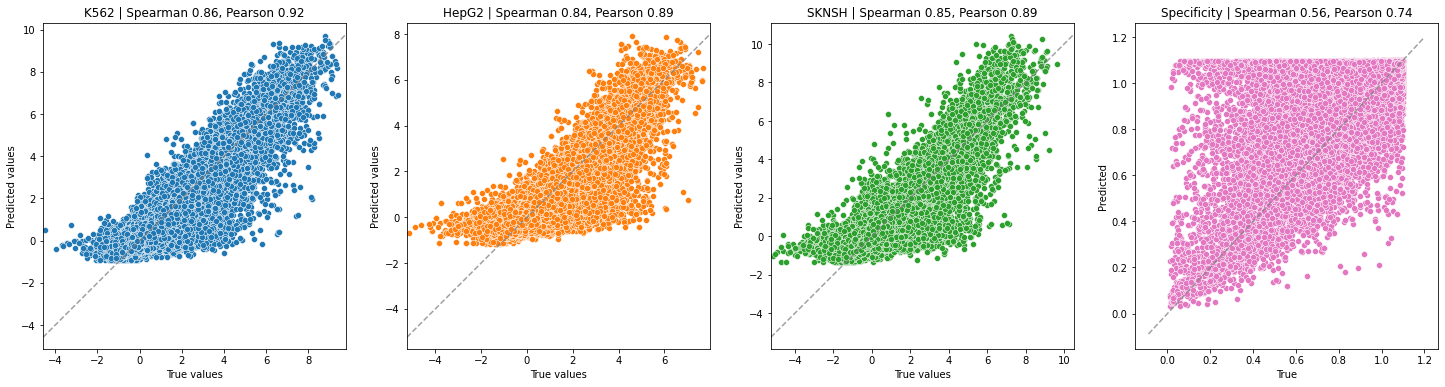

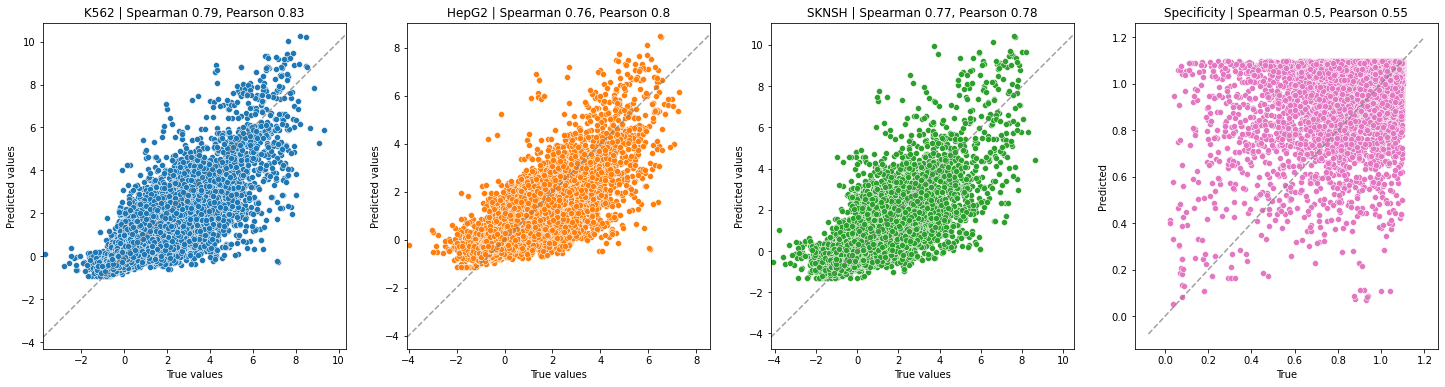

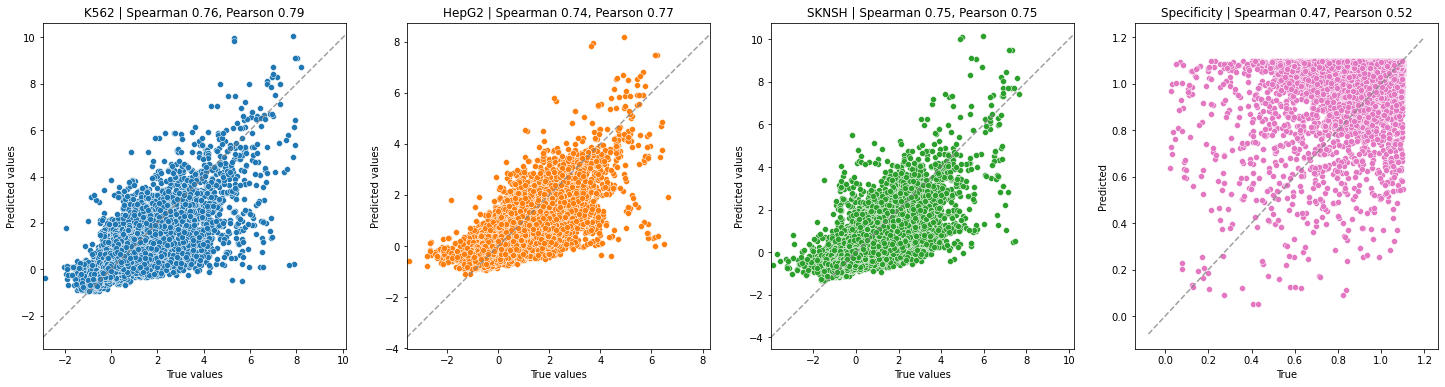

In [176]:
train_truths, train_preds = get_predictions(model, datamodule, dataset='train')
val_truths, val_preds = get_predictions(model, datamodule, dataset='val')
test_truths, test_preds = get_predictions(model, datamodule, dataset='test')
get_scatterplots(train_truths, train_preds, specificity_fn=utils.entropy)
get_scatterplots(val_truths, val_preds, specificity_fn=utils.entropy)
get_scatterplots(test_truths, test_preds, specificity_fn=utils.entropy)


----------------------------------------------
Pearsons: [0.9025464110655597, 0.779369000911271, 0.8502235864685819], average: 0.84
Spearmans: [0.8983492976653448, 0.7812107426937683, 0.8472693457295034], average: 0.84
----------------------------------------------


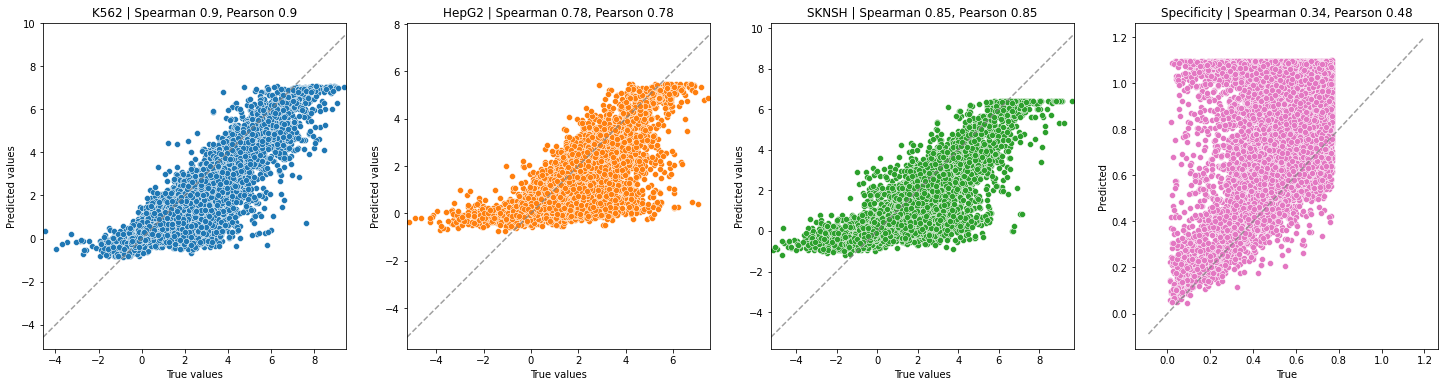

In [152]:
extra_truths, extra_preds = get_predictions(model, datamodule, dataset='extra')
get_scatterplots(extra_truths, extra_preds, specificity_fn=utils.entropy)


----------------------------------------------
Pearsons: [0.8299867580145841, 0.8034942244630798, 0.7965736880993195], average: 0.81
Spearmans: [0.771576726693693, 0.7482507375158186, 0.760787486139462], average: 0.76
----------------------------------------------

----------------------------------------------
Pearsons: [0.7431606906078836, 0.7253898897796461, 0.7094023492481655], average: 0.73
Spearmans: [0.74270504163238, 0.7045780294514905, 0.7212347275416319], average: 0.72
----------------------------------------------


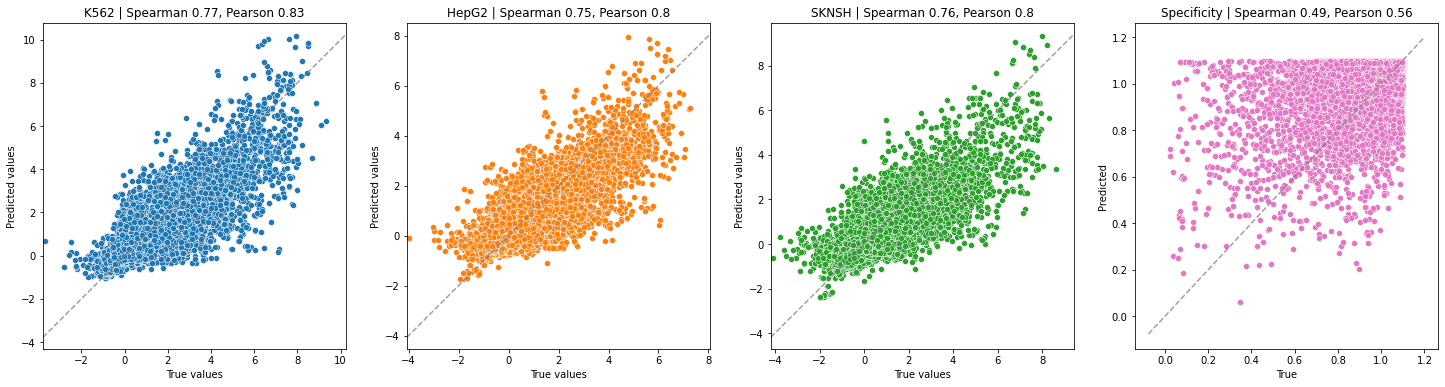

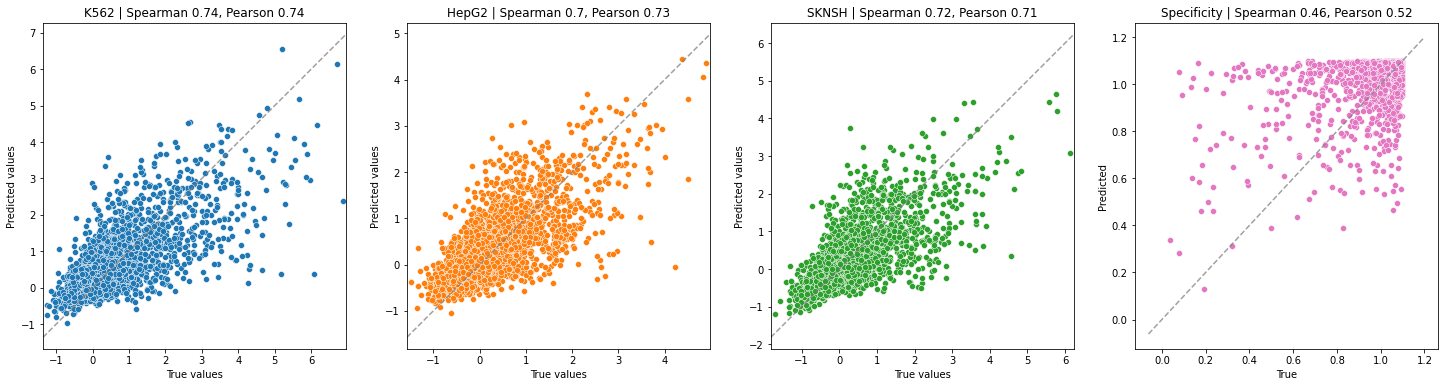

In [113]:
chr_val_truths, chr_val_preds = get_predictions(model, datamodule, dataset='chr_val')
synth_val_truths, synth_val_preds = get_predictions(model, datamodule, dataset='synth_val')
get_scatterplots(chr_val_truths, chr_val_preds, specificity_fn=utils.entropy)
get_scatterplots(synth_val_truths, synth_val_preds, specificity_fn=utils.entropy)


----------------------------------------------
Pearsons: [0.9402781630887767, 0.9092219927043548, 0.9039036806227584], average: 0.92
Spearmans: [0.8724218261165395, 0.8577606228938175, 0.8620265910798446], average: 0.86
----------------------------------------------

----------------------------------------------
Pearsons: [0.9011010307495769, 0.8663285201383504, 0.8533021653953546], average: 0.87
Spearmans: [0.861859683009337, 0.8318354434059496, 0.8433328033865322], average: 0.85
----------------------------------------------


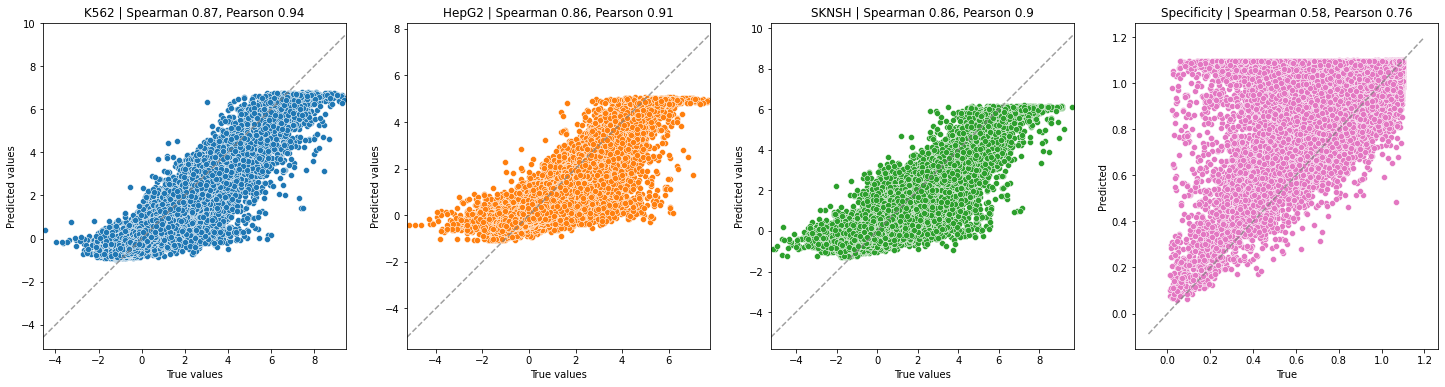

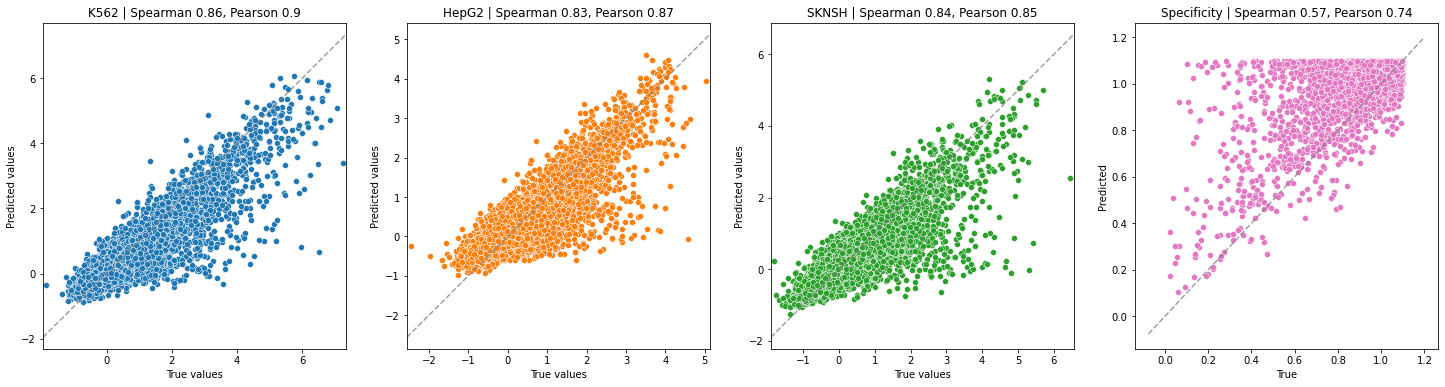

In [75]:
chr_train_truths, chr_train_preds = get_predictions(model, datamodule, dataset='chr_train')
synth_train_truths, synth_train_preds = get_predictions(model, datamodule, dataset='synth_train')
get_scatterplots(chr_train_truths, chr_train_preds, specificity_fn=utils.entropy)
get_scatterplots(synth_train_truths, synth_train_preds, specificity_fn=utils.entropy)

In [169]:
print(model.extra_hidden_size, model.criterion, model.last_activation, model.sneaky_factor, datamodule.doubling_factor)
name = "manual_checkpoint_multioutput_"
name = name + f'lasthidden{model.extra_hidden_size}'
name = name + f'_{model.criterion}'
name = name + f'_{model.last_activation}'.rstrip('Loss')
name = name + f'_sneak{model.sneaky_factor}'
name = name + f'_double{datamodule.doubling_factor}'
print(name)

250 L1Loss() Hardtanh(min_val=-2, max_val=5) 1 0
manual_checkpoint_multioutput_lasthidden250_L1Loss()_Hardtanh(min_val=-2, max_val=5)_sneak1_double0


In [170]:
trainer.save_checkpoint(name)
#trainer.save_checkpoint("manual_checkpoint_multioutput_lasthidden250_smoothL1_ReLU_sneak2double1.ckpt")